## Simple embarrassingly parallel processing for loops in Python

- "[Embarrassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel)" refers to processes that require almost no manipulation for parallelization.
- [Joblib](https://joblib.readthedocs.io/en/latest/index.html) is a package that allows easy parallelization for such processes. See [this nice example and documentation](https://joblib.readthedocs.io/en/latest/parallel.html) provided by the pacakge developers on the topic.

In [1]:
import time
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
import matplotlib.colors as colors

rand_seed = np.random.randint(0, 2**32 - 1)
print(f'random seed:{rand_seed}')

num_cores = multiprocessing.cpu_count()
print(f'Number of cores:{num_cores}')

random seed:244674098
Number of cores:12


In [2]:
%matplotlib notebook

## Example 0:

In [3]:
%%time
test = [np.sqrt(i ** 2) for i in range(100)]

CPU times: user 90 µs, sys: 8 µs, total: 98 µs
Wall time: 99.4 µs


In [4]:
%%time
test = Parallel(n_jobs=2)(delayed(np.sqrt)(i ** 2) for i in range(100))

CPU times: user 22.1 ms, sys: 15.6 ms, total: 37.7 ms
Wall time: 168 ms


As you see above, the non-parallel computation is taking less time. When the process in each iteration is less time consuming than the overhead in splitting the entire process over cores and their communications, this type of parallelization is unlikely to be helpful. 

Here's an example with artificially slower process:

In [5]:
from math import factorial

In [13]:
def slow_sqrt(i):
    timekiller = factorial(2e5)
    return np.sqrt(i ** 2)

In [14]:
%%time
test = [slow_sqrt(i) for i in range(100)]

CPU times: user 29.3 s, sys: 7.38 ms, total: 29.3 s
Wall time: 29.3 s


In [15]:
%%time
test = Parallel(n_jobs=12)(delayed(slow_sqrt)(i) for i in range(100))

CPU times: user 26.3 ms, sys: 12 ms, total: 38.3 ms
Wall time: 5.17 s


## Example 1 - Bootstrap:

<IPython.core.display.Javascript object>


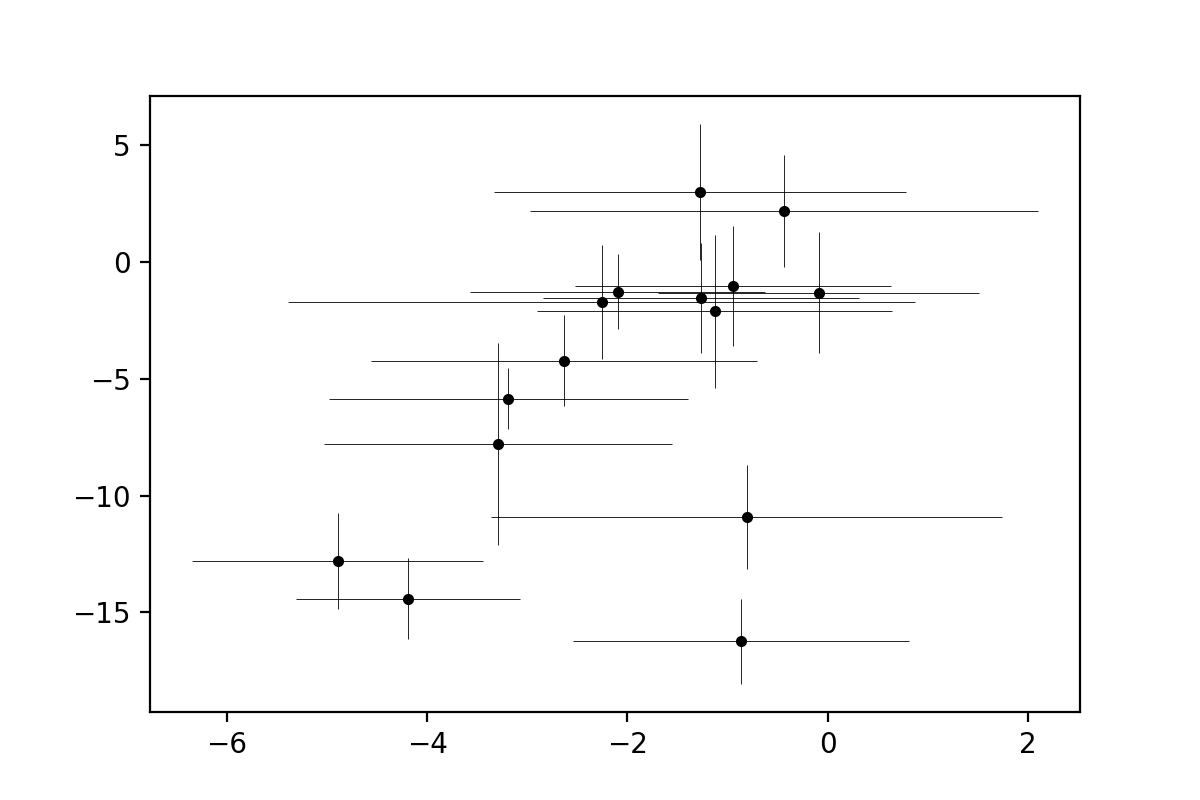

Pearson rank: 0.49551142474224974


In [16]:
numpoints = 15
np.random.seed(seed=rand_seed)
input_x = st.uniform.rvs(-5,5,size=numpoints)
input_dx = st.halfnorm.rvs(1,1,size=numpoints)
input_y = input_x * 2.0 + 1.0 + st.norm.rvs(0,6,size=numpoints)
input_dy = st.halfnorm.rvs(0.5,1,size=numpoints) * 2

fig = plt.figure(figsize=(6,4))
plt.errorbar(input_x,input_y,input_dy,input_dx,fmt='.k',elinewidth=0.3);
print('Pearson rank:',st.pearsonr(input_x,input_y)[0])

In [17]:
def bootstrap_pearson(data_x,data_y,data_dx,data_dy):
    moc_x = np.random.normal(loc=data_x,scale=data_dx)
    moc_y = np.random.normal(loc=data_y,scale=data_dy)
    return moc_x, moc_y, st.pearsonr(moc_x,moc_y)[0]

nsamp = 10000
result = Parallel(n_jobs=num_cores)(delayed(bootstrap_pearson)(input_x,input_y,input_dx,input_dy) for i in range(nsamp))
result = np.array(result)

<IPython.core.display.Javascript object>


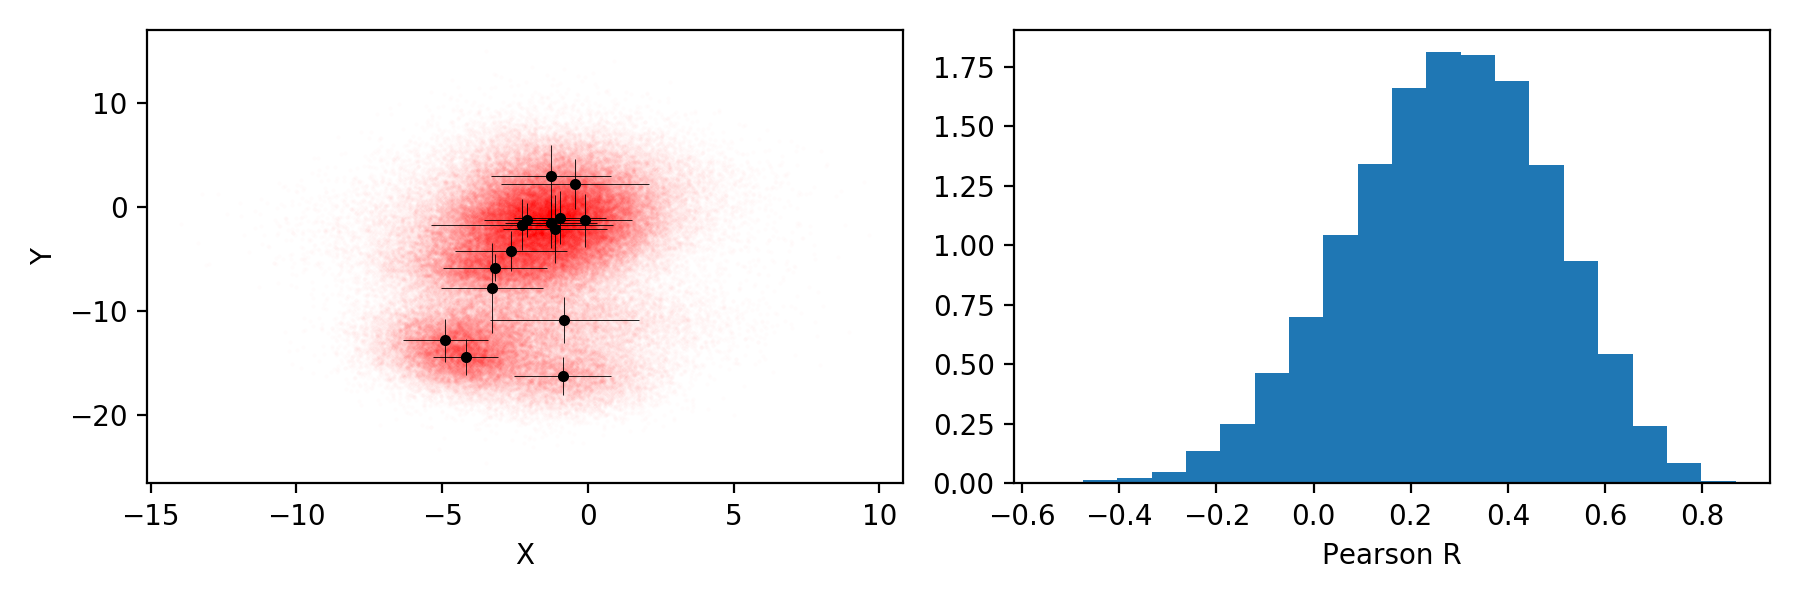

In [18]:
fig = plt.figure(figsize=(9,3))
ax1 = plt.subplot2grid((1,2),(0,0),fig=fig)
for i in range(nsamp):
    plt.plot(result[i][0],result[i][1],'.r',alpha=0.01,ms=1.0)
plt.errorbar(input_x,input_y,input_dy,input_dx,fmt='.k',elinewidth=0.3,zorder=10);
ax1.set(xlabel='X',ylabel='Y')
ax2 = plt.subplot2grid((1,2),(0,1),fig=fig)
plt.hist(result.T[2],bins=20,density=True)
ax2.set(xlabel='Pearson R')
fig.tight_layout()

## Example 2: Grid search

<IPython.core.display.Javascript object>


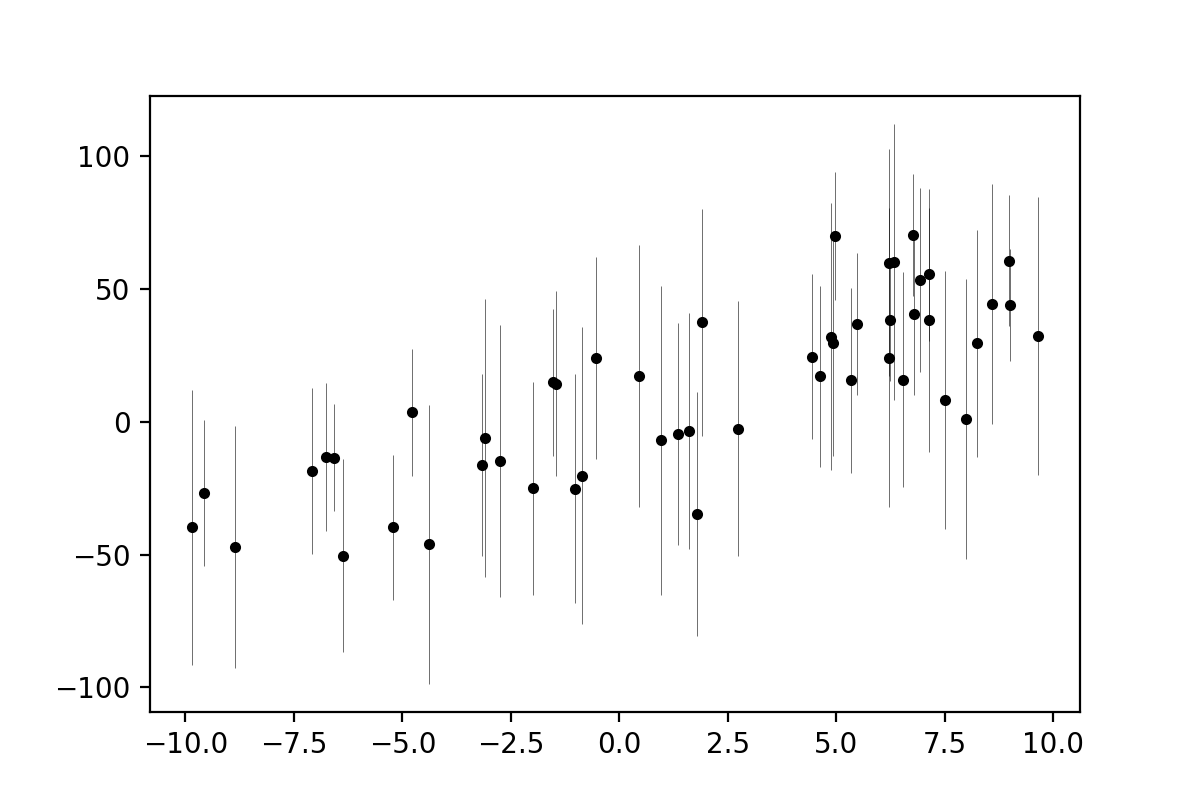

In [19]:
numpoints = 50
np.random.seed(seed=rand_seed)

data_x = st.uniform.rvs(-10.0,20.0,numpoints)
data_y = 5.0 * data_x + 2.0 + st.norm.rvs(0.0,20.0,numpoints)
data_dy = 5*st.uniform.rvs(4.0,8.0,numpoints)

fig = plt.figure(figsize=(6,4))
plt.errorbar(data_x,data_y,data_dy,fmt='.k',elinewidth=0.2);

In [20]:
from scipy.optimize import curve_fit

In [24]:
def line(x,m,d):
    return x*m+d

best_fit_params, cov_matrix = curve_fit(line,data_x,data_y,sigma=data_dy)
best_fit_params

array([4.81785748, 8.94958689])

<IPython.core.display.Javascript object>


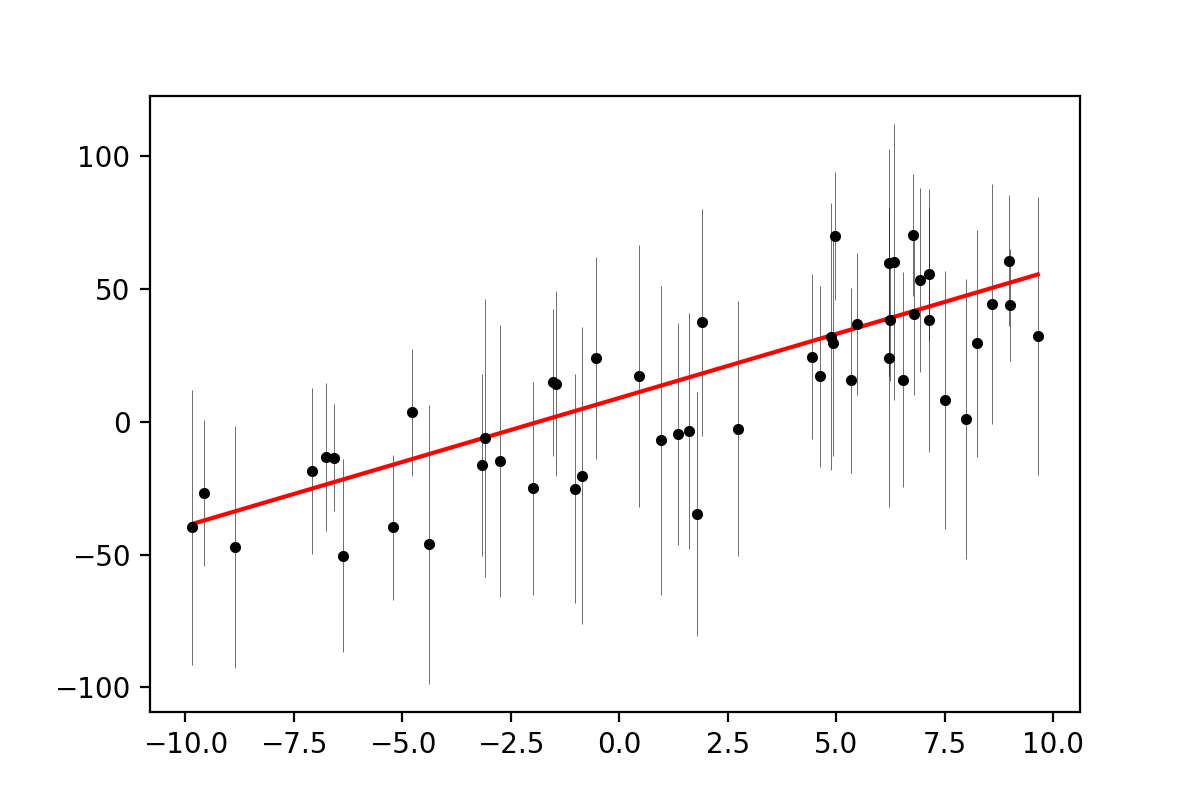

In [25]:
model_x = np.linspace(min(data_x),max(data_x),100)
model_y = line(model_x, best_fit_params[0],best_fit_params[1])

fig = plt.figure(figsize=(6,4))
plt.errorbar(data_x,data_y,data_dy,fmt='.k',elinewidth=0.2);
plt.plot(model_x,model_y,'-r')

$$ \chi^2 = \sum_i\frac{(y_i - f(x_i))^2}{\sigma_i^2} $$
$$ \chi^2_\nu = \frac{\chi^2}{\text{D.O.F}} $$

In [26]:
def chi2(m,d,x,y,dy):
    return sum(((y - (m * x + d))/dy)**2)

axis_grid_points = 1000
m_array = np.linspace(3,7,axis_grid_points)
d_array = np.linspace(-25,30,axis_grid_points)

In [27]:
chi2_array = Parallel(n_jobs=num_cores)(delayed(chi2)(m_i,d_i,data_x,data_y,data_dy) for m_i in m_array for d_i in d_array)

<IPython.core.display.Javascript object>


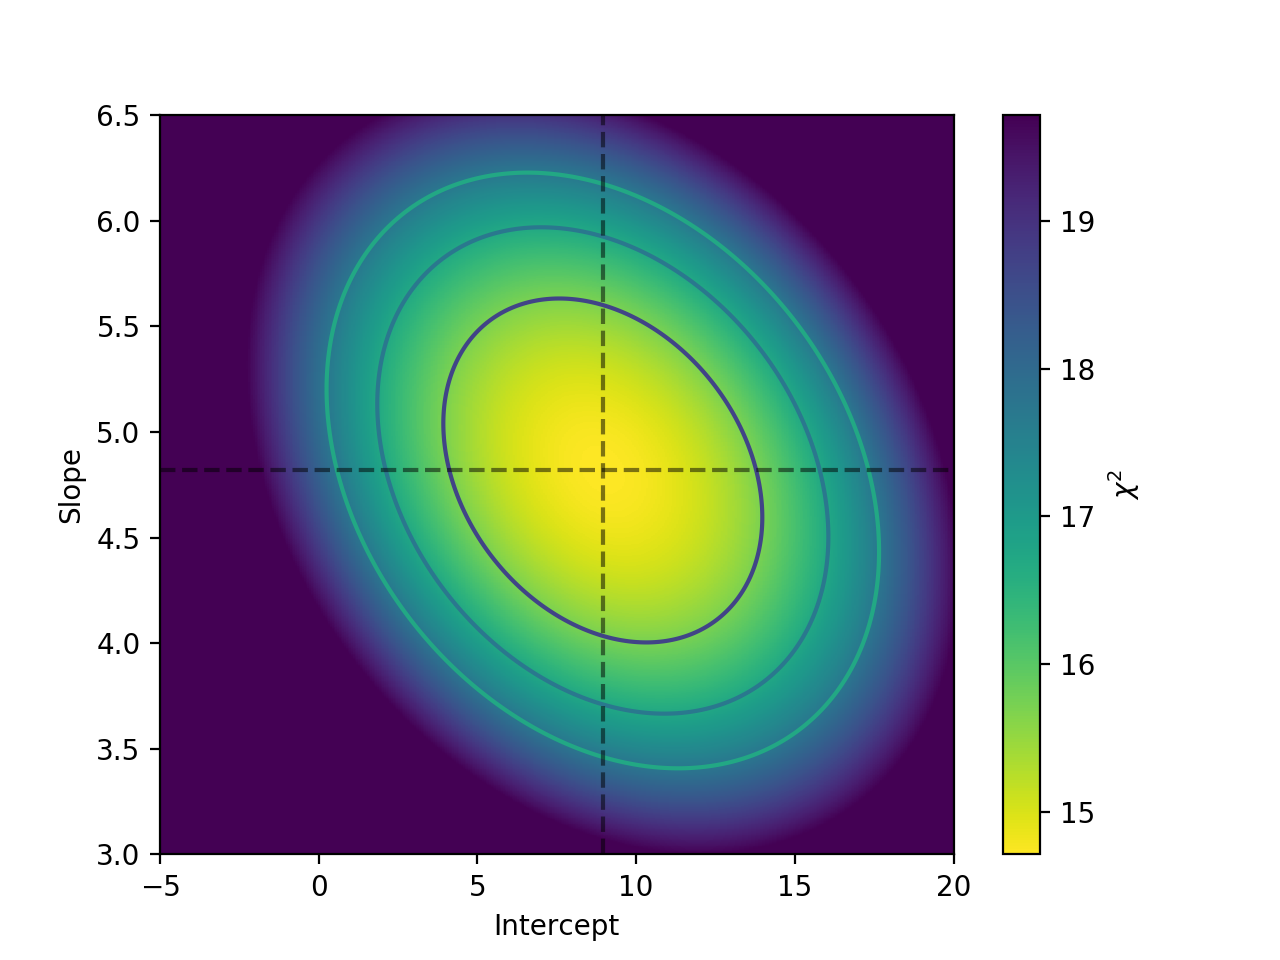

In [33]:
chi2_matrix = np.reshape(chi2_array, (-1, len(d_array)))
min_redchi2 = chi2_matrix.min()

cmap = plt.cm.viridis_r
cmap.set_bad('black')
cmap_norm = colors.Normalize(vmin=chi2_matrix.min(), vmax=chi2_matrix.min()+5)

fig = plt.figure()
img = plt.imshow(chi2_matrix, origin='lower', cmap=cmap, norm=cmap_norm, aspect='auto',
                 extent=[d_array.min(), d_array.max(),m_array.min(),m_array.max()])
plt.axhline(best_fit_params[0],linestyle='--',color='k',alpha=0.5)
plt.axvline(best_fit_params[1],linestyle='--',color='k',alpha=0.5)


cbar = plt.colorbar(img)
clevels = [min_redchi2+1,min_redchi2+2,min_redchi2+3]
contours = plt.contour(d_array,m_array,chi2_matrix,clevels,cmap='viridis',norm=cmap_norm)
fig.axes[0].set(xlim=[-5,20],ylim=(3.0,6.5),xlabel='Intercept',ylabel='Slope')
fig.axes[1].set(ylabel=r'$\chi^2$');